In [0]:
from tensorflow.python.client import device_lib

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Loading

In [0]:
data_train = pd.read_csv('/content/drive/My Drive/MSIT 2nd Year/ML course/Projects/FInal Code/train.csv')
data_train.text[1]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

1    10413
0    10387
Name: label, dtype: int64


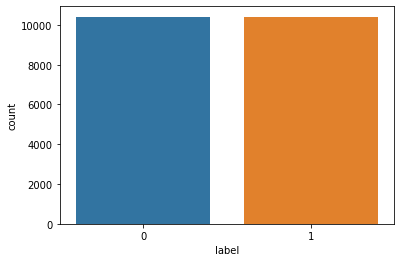

In [0]:
print(data_train['label'].value_counts())
sns.countplot(data_train['label'])

# Text Pre-processing

In [0]:
print(data_train.columns)
print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text1 = data_train.title[i]
    text2 = data_train.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
   id  ... label
0   0  ...     1
1   1  ...     0
2   2  ...     1
3   3  ...     1
4   4  ...     1

[5 rows x 5 columns]
Found 251876 unique tokens.


In [0]:
print(texts[:1], '\n',sequences[:1], '\n',list(word_index.keys())[:5],max(list(word_index.values())), word_index['dem'])

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted ItHouse Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House In

In [0]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20800, 1000)
Shape of label tensor: (20800, 2)


In [0]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 16640 10400 10400
real & fake news in train,valt,test:
[8294. 8346.]
[5192. 5208.]
[5195. 5205.]


In [0]:
#Using Pre-trained word embeddings
GLOVE_DIR = "/content/drive/My Drive/MSIT 2nd Year/ML course/Projects/FInal Code/" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    # print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.



# Simple CNN

In [0]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

In [0]:
print("Fitting the simple convolutional neural network model")
model.summary()

Fitting the simple convolutional neural network model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         25187700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128)

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16640 samples, validate on 10400 samples
Epoch 1/3
16640/16640 [==============================] - 262s 16ms/step - loss: 0.6584 - acc: 0.5986 - val_loss: 0.6280 - val_acc: 0.6294
Epoch 2/3
16640/16640 [==============================] - 259s 16ms/step - loss: 0.5420 - acc: 0.7316 - val_loss: 0.3512 - val_acc: 0.8662
Epoch 3/3
16640/16640 [==============================] - 261s 16ms/step - loss: 0.3445 - acc: 0.8480 - val_loss: 0.2296 - val_acc: 0.9117


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


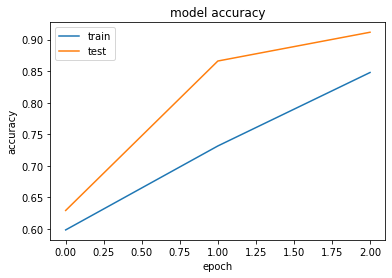

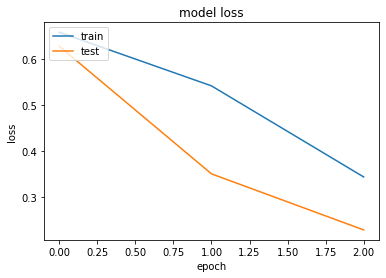

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the plot
plt.savefig('simple_CNN_acc.png', bbox_inches='tight')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Save the plot
plt.savefig('simple_CNN_loss.png', bbox_inches='tight')

In [0]:
# Simple CNN model2
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

# Complex conv

In [0]:
#convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
# l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_merge = Concatenate()(convs)

l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
model2.summary()
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=50)
model2.save('model.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
  


Fitting a more complex convolutional neural network model
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    25187700    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 998, 128)     38528       embedding_1[2][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 997, 128)     51328       embedding_1[2][0]                
__________________________________

In [0]:
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=50)
model2.save('model.h5')

In [0]:
# list all data in history
print(history2.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing models

In [0]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])